<a href="https://colab.research.google.com/github/prabhkaur301/ML-notebooks/blob/main/malicious_url_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install sklearn==0.0.post1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns 
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.core.common import random_state
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


In [ ]:
url_dataset=pd.read_csv('/content/drive/MyDrive/Major project/Malicious Url Detector/urldata.csv')

In [ ]:
url_dataset

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
...,...,...
420459,23.227.196.215/,bad
420460,apple-checker.org/,bad
420461,apple-iclods.org/,bad
420462,apple-uptoday.org/,bad


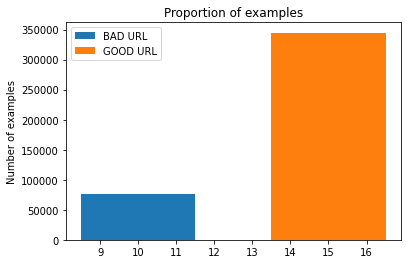

In [ ]:
%matplotlib inline
BAD_len = url_dataset[url_dataset['label'] == 'bad'].shape[0]
GOOD_len = url_dataset[url_dataset['label'] == 'good'].shape[0]
plt.bar(10,BAD_len,3, label='BAD URL')
plt.bar(15,GOOD_len,3, label='GOOD URL')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

## Removal of null values

In [ ]:
url_dataset['url'].isna().sum()
url_dataset['label'].isna().sum()

0

In [ ]:
url_dataset= url_dataset[pd.notnull(url_dataset['url'])]

## Label to numerical category

In [ ]:
url_dataset['category_id'] = url_dataset['label'].factorize()[0]
category_id_df = url_dataset[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)

In [ ]:
url_dataset

,url,label,category_id
0,diaryofagameaddict.com,bad,0
1,espdesign.com.au,bad,0
2,iamagameaddict.com,bad,0
3,kalantzis.net,bad,0
4,slightlyoffcenter.net,bad,0
...,...,...,...
420459,23.227.196.215/,bad,0
420460,apple-checker.org/,bad,0
420461,apple-iclods.org/,bad,0
420462,apple-uptoday.org/,bad,0


## Shuffled Dataset

In [ ]:
url_dataset = url_dataset.sample(frac = 1)

In [ ]:
url_dataset

,url,label,category_id
32713,hlynge.dk/new/DHL/,bad,0
62733,cityroom.blogs.nytimes.com/author/dan-bilefsky/,good,1
328175,rockmnation.com/section/mizzou-football-2010,good,1
375232,youtube.com/watch?v=5G3xhMxTb_U,good,1
360235,usa-people-search.com/Find-J-Cooper-Novato-CA-...,good,1
...,...,...,...
95552,funky16corners.tripod.com/earland_discography.htm,good,1
274337,last.fm/music/Black+Ox+Orkestar/_/Bukharian,good,1
302010,mylifetime.com/movies/too-rich-the-secret-life...,good,1
405738,maggycocoa.net/i9uje,bad,0


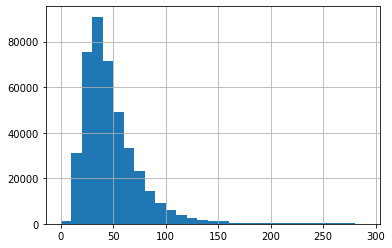

In [ ]:
%matplotlib inline
lens = url_dataset.url.str.len()
lens.hist(bins = np.arange(0,300,10))

In [ ]:
# converting to all lowercase
url_dataset['url'] = url_dataset['url'].apply(lambda x: x.lower())
url_dataset.head()

,url,label,category_id
32713,hlynge.dk/new/dhl/,bad,0
62733,cityroom.blogs.nytimes.com/author/dan-bilefsky/,good,1
328175,rockmnation.com/section/mizzou-football-2010,good,1
375232,youtube.com/watch?v=5g3xhmxtb_u,good,1
360235,usa-people-search.com/find-j-cooper-novato-ca-...,good,1


In [ ]:
url_dataset['url'] = url_dataset['url'].str.replace('.com', '')

<ipython-input-18-7c0cf912ba23>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  url_dataset['url'] = url_dataset['url'].str.replace('.com', '')


In [ ]:
url_dataset

,url,label,category_id
32713,hlynge.dk/new/dhl/,bad,0
62733,cityroom.blogs.nytimes/author/dan-bilefsky/,good,1
328175,rockmnation/section/mizzou-football-2010,good,1
375232,youtube/watch?v=5g3xhmxtb_u,good,1
360235,usa-people-search/find-j-cooper-novato-ca-9494...,good,1
...,...,...,...
95552,funky16corners.tripod/earland_discography.htm,good,1
274337,last.fm/music/black+ox+orkestar/_/bukharian,good,1
302010,mylifetime/movies/too-rich-the-secret-life-of-...,good,1
405738,maggycocoa.net/i9uje,bad,0


## Spacy Library for Word Embedding

In [ ]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import spacy
spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg", disable=['ner', 'parser'])

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
url_dataset["url_vec"]=url_dataset["url"].apply(lambda url: nlp(url).vector)
url_dataset

,url,label,category_id,url_vec
32713,hlynge.dk/new/dhl/,bad,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
62733,cityroom.blogs.nytimes/author/dan-bilefsky/,good,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
328175,rockmnation/section/mizzou-football-2010,good,1,"[-1.8601857, -1.2178859, 4.004714, 2.7033713, ..."
375232,youtube/watch?v=5g3xhmxtb_u,good,1,"[-0.83218336, -1.3717266, 3.5792332, 0.0533666..."
360235,usa-people-search/find-j-cooper-novato-ca-9494...,good,1,"[-1.7488434, 1.7868881, -0.29803136, 4.3517346..."
...,...,...,...,...
95552,funky16corners.tripod/earland_discography.htm,good,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
274337,last.fm/music/black+ox+orkestar/_/bukharian,good,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
302010,mylifetime/movies/too-rich-the-secret-life-of-...,good,1,"[-3.1871552, 0.18357685, -0.17126107, 4.067987..."
405738,maggycocoa.net/i9uje,bad,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
url_dataset.to_csv('/content/drive/MyDrive/Major project/Malicious Url Detector/processed_data.csv')

In [ ]:
url_train,url_test, label_train, label_test = train_test_split(url_dataset.url_vec.values, url_dataset.category_id, test_size=0.2, random_state=2022)

In [ ]:
url_train_2D = np.stack(url_train)
url_test_2D = np.stack(url_test)

In [ ]:
models= dict()

Multinomial Naive Bayes

In [ ]:
mnb = MultinomialNB()
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(url_train_2D) #Negative values in data passed to MultinomialNB (input X)
scaled_test = scaler.transform(url_test_2D)
mnb.fit(scaled_train, label_train) # scaled to get positive range of numbers for pos & neg data

MultinomialNB()

In [ ]:
label_pred = mnb.predict(scaled_test)
print(classification_report(label_test, label_pred))
print("accuracy: {}%".format(round(accuracy_score(label_test, label_pred)*100,2)))
models['MultinomialNB()']=round(accuracy_score(label_test, label_pred)*100,2)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15140
           1       0.82      1.00      0.90     68953

    accuracy                           0.82     84093
   macro avg       0.41      0.50      0.45     84093
weighted avg       0.67      0.82      0.74     84093

accuracy: 82.0%


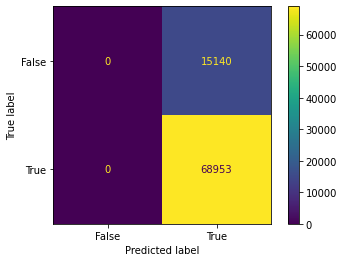

In [ ]:
confusion_matrix_nb = confusion_matrix(label_test, label_pred)
cm_display= ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_nb, display_labels = [False, True])
cm_display.plot()
plt.show() 

KNN

In [ ]:
# knn = KNeighborsClassifier(n_neighbors = 5, metric = "euclidean")
# knn.fit(url_train_2D, label_train)

KNeighborsClassifier(metric='euclidean')

In [ ]:
# label_pred_knn = knn.predict(url_test_2D)
# print(classification_report(label_test, label_pred_knn))
# print("accuracy: {}%".format(round(accuracy_score(label_test, label_pred_knn)*100,2)))
# models['KNN']=round(accuracy_score(label_test, label_pred_knn)*100,2)

              precision    recall  f1-score   support

           0       0.83      0.21      0.33     15140
           1       0.85      0.99      0.92     68953

    accuracy                           0.85     84093
   macro avg       0.84      0.60      0.62     84093
weighted avg       0.85      0.85      0.81     84093

accuracy: 84.95%


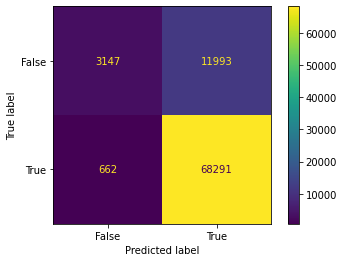

In [ ]:
confusion_matrix_knn = confusion_matrix(label_test, label_pred_knn)
cm_display= ConfusionMatrixDisplay(confusion_matrix_knn ,display_labels = [False, True])
cm_display.plot()
plt.show() 

Random Forest

In [ ]:
confusion_matrix_rd = confusion_matrix(label_test, label_pred_randfor)
cm_display= ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rd, display_labels = [False, True])
cm_display.plot()
plt.show() 

Final Performance Analysis of Models

In [ ]:
plt.figure(figsize=(8,7))
plt.bar(list(models.keys()),list(models.values()))
plt.ylim(80,100)
plt.ylabel('Model Accuracy')
plt.title('Comparison of Accuracy of models')
plt.show()